In [1]:
%%capture
import tensorflow as tf
from tensorflow import keras
from scipy.io import loadmat
from tensorflow.keras import regularizers
from sklearn.utils import shuffle
import os
import time
import numpy as np
import gc
from tensorflow.keras.models import model_from_json
!pip install tqdm
!pip install h5py
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from sklearn.metrics import r2_score
from sklearn import preprocessing

In [2]:
def scale(x):

    return (x - np.mean(x)) / np.std(x)

In [3]:
def preprocess(x):
    
    return x[:,:,:int(0.75*x.shape[2])]

In [5]:
os.chdir("/home/pk2573/Capstone_Data/Re1243Fr20/coarse8")
u = preprocess(scale(loadmat('u_F_xyz_T1.mat')["u_F"]))
v = preprocess(scale(loadmat('v_F_xyz_T1.mat')["v_F"]))
w = preprocess(scale(loadmat('w_F_xyz_T1.mat')["w_F"]))
tau_12 = preprocess(scale(loadmat('tau12_F_xyz_T1.mat')["tau12"]))
tau_13 = preprocess(scale(loadmat('tau13_F_xyz_T1.mat')["tau13"]))
tau_23 = preprocess(scale(loadmat('tau23_F_xyz_T1.mat')["tau23"]))

In [6]:
x = np.array([u, v, w])
x = np.transpose(x, [1, 2, 3, 0])
x = np.pad(x, ((3,3), (3,3), (3,3), (0,0)), 'constant', constant_values = 0)

In [7]:
sample = []
size = 3
y_tau_12 = []
y_tau_13 = []
y_tau_23 = []
for k in tqdm_notebook(range(size, x.shape[2] - size)):
    for i in range(size, x.shape[0] - size):
        for j in range(size, x.shape[1] - size):
            sample.append(x[i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, :])
            y_tau_12.append(tau_12[i - size][j - size][k - size])
            y_tau_13.append(tau_13[i - size][j - size][k - size])
            y_tau_23.append(tau_23[i - size][j - size][k - size])

In [8]:
x = np.stack(sample, axis = 0)
del sample
gc.collect()
print(x.shape)

y_tau_12 = np.array(y_tau_12)
y_tau_13 = np.array(y_tau_13)
y_tau_23 = np.array(y_tau_23)

(784896, 7, 7, 7, 3)


In [9]:
class DNN(object):
    
    def __init__(self, activation, x_train, y_train, epochs, batch_size, input_shape, val_split, initializer):
        self.activation = activation
        self.x_train = x_train
        self.y_train = y_train
        self.epochs = epochs
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.val_split = val_split
        self.initializer = initializer
        
        pass 
    
    def create_model(self):
        model = keras.Sequential([
            tf.keras.layers.Flatten(input_shape = self.input_shape),
            tf.keras.layers.Dense(128, 
                             activation = self.activation,
                             kernel_initializer = self.initializer),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(64, 
                             activation = self.activation,
                             kernel_initializer = self.initializer),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(32, 
                             activation = self.activation,
                             kernel_initializer = self.initializer),
            tf.keras.layers.Dense(1)
        ])
        
        return model
    
    def callbacks(self):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               min_delta = 0.001,
                                               patience = 0,
                                               verbose = 0)
        
        return early_stopping
    
    def run_model(self):
        model = self.create_model()
        model.compile(optimizer = tf.train.AdamOptimizer(), 
              loss = "mse")
        
        history = model.fit(self.x_train, self.y_train, 
                    epochs = self.epochs, 
                    validation_split = self.val_split, 
                    batch_size =  self.batch_size,
                    verbose = 0)
        
        return history, model

Predicting tau_12
R^2: 0.7269
Correlation: 0.8908

Predicting tau_13
R^2: 0.7816
Correlation: 0.9219

Predicting tau_23
R^2: 0.7309
Correlation: 0.9060



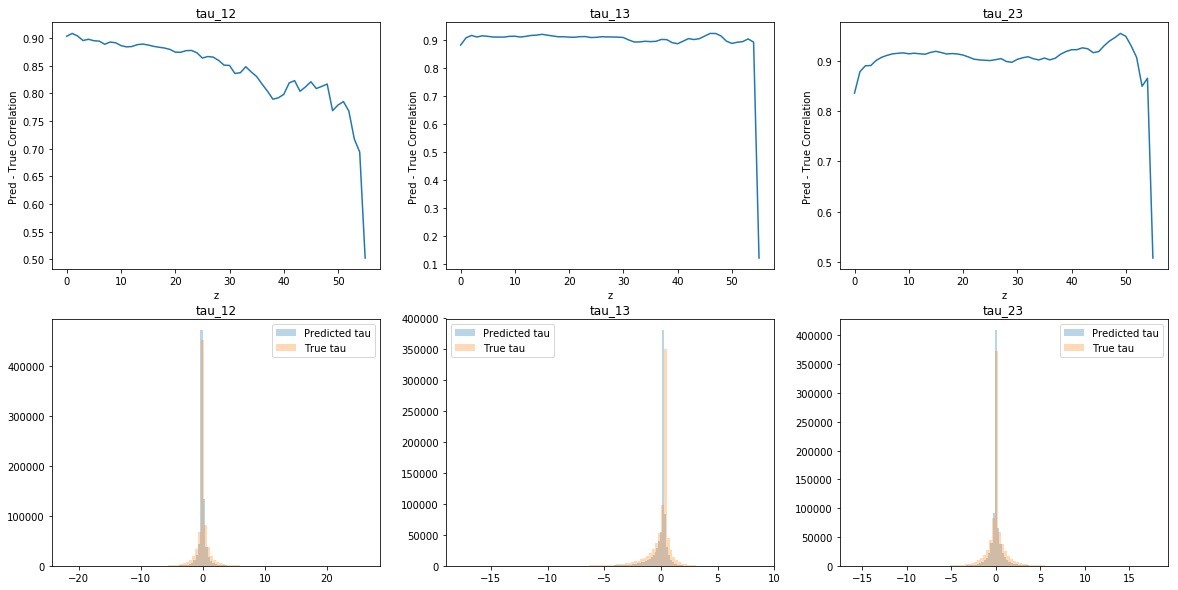

In [10]:
taus = [(y_tau_12, "tau_12"), (y_tau_13, "tau_13"), (y_tau_23, "tau_23")]
fig = plt.figure(figsize = (20, 10))
activation = tf.nn.relu
epochs = 50
initializer = tf.glorot_uniform_initializer
batch_size = 1000
val_split = 0.2

num = 1
for (y, name) in taus:
    print("Predicting " + name)
    x_train, y_train = shuffle(x, y, random_state = 0)
   
    input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3], x_train.shape[4])
    model = DNN(activation, x_train, y_train, epochs, batch_size, input_shape, val_split, initializer)        
    history, model = model.run_model()
    
    y_pred = model.predict(x).flatten()
    y_true = y
    print("R^2: %.4f" % r2_score(y_true, y_pred))
    print("Correlation: %.4f\n" % np.corrcoef(y_pred, y_true)[0, 1])

    corr = []
    for i in range(u.shape[2]):
        corr.append(np.corrcoef(y_pred[i*u.shape[0]*u.shape[1]:(i+1)*u.shape[0]*u.shape[1]], y_true[i*u.shape[0]*u.shape[1]:(i+1)*u.shape[0]*u.shape[1]])[0, 1])
    
    fig.add_subplot(2, len(taus), num)
    plt.plot(corr)
    plt.xlabel('z')
    plt.ylabel('Pred - True Correlation')
    plt.title(name)
    plt.show
    
    fig.add_subplot(2, len(taus), num + 3)
    n_bins = 100
    plt.hist(y_pred, bins = n_bins, alpha = 0.3, label = "Predicted tau")
    plt.hist(y_true, bins = n_bins, alpha = 0.3, label = "True tau")
    plt.title(name)
    plt.legend()
    plt.show
    
    del x_train
    del y_train
    del y_pred
    del y_true
    gc.collect()
    num += 1